## MIDS - Spotify Base Data Review

In [ ]:
# base modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.metrics

# non-base no import
from pathlib import Path
from bs4 import BeautifulSoup
#from lyricsgenius import Genius
import requests
import seaborn as sns
import json
import xgboost as xgb
import os
import re

In [ ]:
# import packages
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from musixmatch import Musixmatch
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
#Spotify creds
cid = Path('_keys/cid.txt').read_text()
secret = Path('_keys/secret.txt').read_text()

#Genius creds
genius_cid = Path('_keys/genius_cid.txt').read_text()
genius_secret = Path('_keys/genius_secret.txt').read_text()

#Musixmatch creds
musix_cid = Path('_keys/musix_id.txt').read_text()

In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#genius = Genius(genius_cid)

In [ ]:
genres = pd.read_csv('_data/genres_v2.csv')
playlist = pd.read_csv('_data/playlists.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
genres['genre'].value_counts()

Underground Rap    5875
Dark Trap          4578
Hiphop             3028
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
techno             2956
hardstyle          2936
RnB                2099
Trap Metal         1956
Rap                1848
Emo                1680
Pop                 461
Name: genre, dtype: int64

In [ ]:
## subset to just electro-related count
use_genres = ['trance', 'techhouse', 'dnb', 'techno']

electro_songs = genres[genres.genre.isin(use_genres)]

In [ ]:
## get song popularity
def popularity(df):
    empty = []
    for i in df['uri']:
            series_track = pd.Series(sp.track(i))
            empty.append(series_track)
    df2 = pd.DataFrame(empty)
    return df2

electro_popularity = popularity(electro_songs)

ReadTimeout: ignored

In [ ]:
electro_popularity

NameError: ignored

In [ ]:
electro_popularity.to_csv('elctro_pull.csv')

In [ ]:
electro_popularity = pd.read_csv('elctro_pull.csv')

Plot distribution of popularity score.

[Text(0.5, 1.0, 'Total Popularity Distribution')]

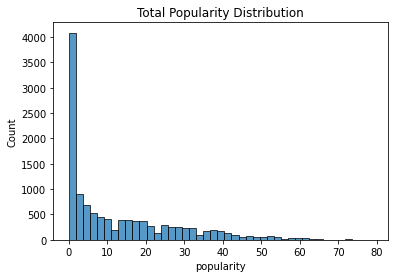

In [ ]:
sns.histplot(data = electro_popularity
            ,x = 'popularity'
            ).set(title='Total Popularity Distribution')

[Text(0.5, 1.0, 'Non-0 Popularity Distribution')]

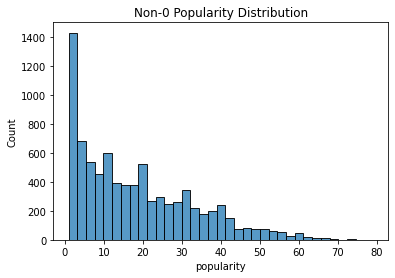

In [ ]:
sns.histplot(data = electro_popularity.loc[electro_popularity['popularity'] > 0]
            ,x = 'popularity'
            ).set(title='Non-0 Popularity Distribution')

In [ ]:
## remove any songs with no popularity - assuming these are too small to be considered
electro_short = electro_popularity.loc[electro_popularity['popularity'] > 0]

In [ ]:
# parse artist names from JSON response
def parse_artist(df):
  empty = []
  for i in df['artists']:
    line_artists = []
    try:
      artist_lists = json.loads(i.replace("\'", "\""))
    except:
      #print(i)
      artists_lists = []
    for j in artist_lists:
      line_artists.append(j['name'])
    empty.append(line_artists)
  return empty


electro_short['artist_names'] = parse_artist(electro_short)
electro_short['first_artist'] = electro_short.apply(lambda row: row.artist_names[0], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
out = pd.DataFrame(electro_short.first_artist.value_counts())
out

,first_artist
Armin van Buuren,84
Aly & Fila,73
Above & Beyond,50
Walker & Royce,41
Cloonee,40
...,...
Gareth Wild,1
Sinfol,1
Underworld,1
Maelstrom,1


[Text(0.5, 1.0, 'Arist Song Count')]

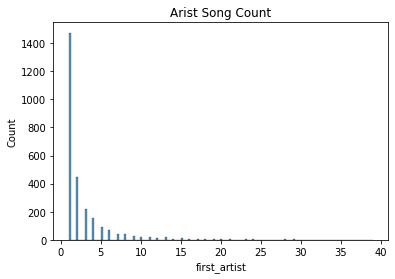

In [ ]:
sns.histplot(data = out.loc[out['first_artist'] < 40]
            ,x = 'first_artist'
            ).set(title='Arist Song Count')

In [ ]:
use_cols = ['href', 'popularity', 'name', 'first_artist']
electro_short_join = electro_short[use_cols]

In [ ]:
electro_short_join

,href,popularity,name,first_artist
0,https://api.spotify.com/v1/tracks/5LzAV6KfjN8V...,30,Sauce,Max Chapman
1,https://api.spotify.com/v1/tracks/6nxvhvk9etkP...,24,Music Please,Detlef
2,https://api.spotify.com/v1/tracks/3TsCb6ueD678...,22,Ooh Tune - Danny Howard Remix,Shadow Child
3,https://api.spotify.com/v1/tracks/6Y0Fy2buEis7...,2,Dust (feat. Badbox),Robin M
4,https://api.spotify.com/v1/tracks/4EJI2XGViSQp...,50,Pretty Baby,Redondo
...,...,...,...,...
11889,https://api.spotify.com/v1/tracks/7glEDEzVhstE...,3,Gold,Ownglow
11890,https://api.spotify.com/v1/tracks/2m9oMX34OOMK...,35,Demons,T & Sugah
11891,https://api.spotify.com/v1/tracks/3aezqOl72dNj...,2,Bitter Professional,Sinic
11894,https://api.spotify.com/v1/tracks/1C7gZX83AIi5...,8,Don't Hold Back,Bachelors of Science


In [ ]:
genres_joined = pd.merge(genres.drop('genre', axis=1).drop_duplicates(), 
                         electro_short_join.drop_duplicates(),
                         left_on='track_href', right_on='href', how='left')
genres_joined_electro = genres_joined.loc[~pd.isna(genres_joined.first_artist)]

In [ ]:
genres_joined_electro.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'song_name', 'Unnamed: 0', 'title', 'href',
       'popularity', 'name', 'first_artist'],
      dtype='object')

In [ ]:
agg_cols = {'danceability':'mean',
            'energy':'mean',
            'key': 'mean',
            'loudness':'mean',
            #'mode':'mean',
            'speechiness':'mean',
            'acousticness':'mean',
            'instrumentalness':'mean',
            'liveness': 'mean',
            'valence':'mean',
            'tempo':'mean',
            'popularity': 'mean'}

electro_agg_metrics = genres_joined_electro.groupby('first_artist').agg(agg_cols)

In [ ]:
electro_agg_metrics

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
first_artist,,,,,,,,,,,
1991,0.451444,0.878556,4.944444,-3.23400,0.046628,0.012991,0.340653,0.235772,0.351944,174.024111,32.333333
1st in Line,0.194000,0.999000,10.000000,-4.74900,0.097300,0.000621,0.915000,0.344000,0.257000,137.979000,13.000000
2000 And One,0.787750,0.850500,4.750000,-8.60525,0.045800,0.000097,0.862500,0.209750,0.066175,129.759250,8.250000
2pole,0.740000,0.812375,5.000000,-7.91075,0.088175,0.013872,0.808125,0.111025,0.111687,130.130750,13.125000
4 Strings,0.485550,0.869150,5.050000,-7.64460,0.066450,0.004663,0.317804,0.273420,0.098530,135.702300,8.650000
...,...,...,...,...,...,...,...,...,...,...,...
tEho & Tran,0.762000,0.444000,4.000000,-13.91500,0.049700,0.013200,0.877000,0.059000,0.366000,121.994000,2.000000
tranzLift,0.509000,0.926750,6.000000,-7.62425,0.071125,0.000491,0.882000,0.340000,0.186750,138.497250,4.750000
twoloud,0.735000,0.853000,0.000000,-6.34200,0.074800,0.000719,0.393000,0.158000,0.489000,124.976000,6.000000


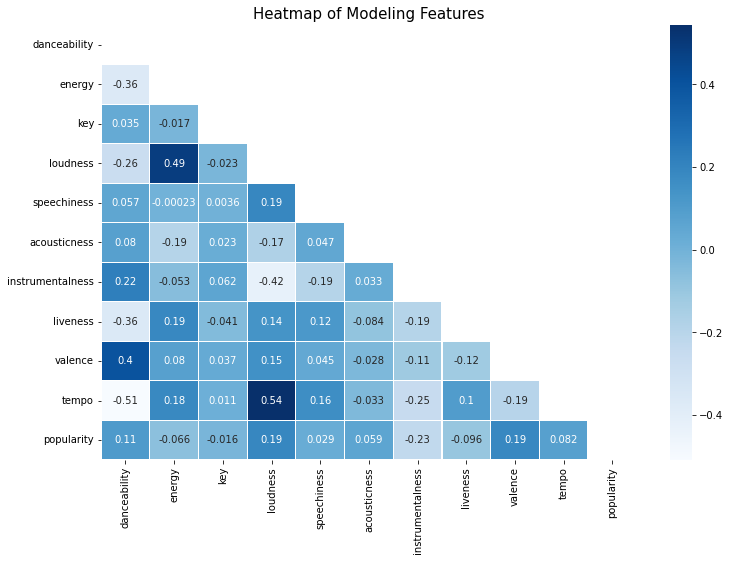

In [ ]:
corr = electro_agg_metrics.corr()

fig, ax = plt.subplots(figsize = (12,8))

sns.heatmap(corr, mask = np.triu(np.ones_like(corr, dtype = bool)), cmap = 'Blues', annot = True, 
           linewidths = .2)

plt.title('Heatmap of Modeling Features', fontsize = 15)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('popularity', axis = 1), 
                                                                            electro_agg_metrics.popularity,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [ ]:
## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
        else:
            pass
    else:
        results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
    print(results)

In [ ]:
XGB_MVP = xgb.XGBRegressor(objective='reg:squarederror',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base")

{'XGB_Base': 11.956169955299229}


In [ ]:
## Run GridSearchCV on max_depth, min_child_weight, n_estimators, and subsample

param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(3,10,2),
 'subsample':[i/100.0 for i in range(70,90,5)],
 'n_estimator':range(150,300,50)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eta=0.025,
                                                                           seed=100),param_grid=param_test, 
                                                                           cv=4)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

XGBRegressor(eta=0.025, min_child_weight=9, n_estimator=150,
             objective='reg:squarederror', seed=100, subsample=0.75)

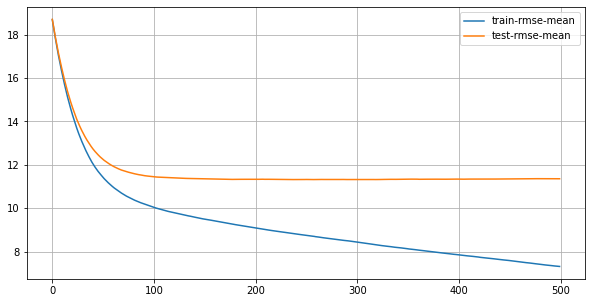

In [ ]:
## Select final number of estimators
params = {'eta':0.025, 'seed':100, 
         'max_depth':4, 'min_child_weight':9, 'subsample':0.75, 'objective':'reg:squarederror'}

## Run CV to determine the number of round
CVRun = xgb.cv(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=500,
            nfold=4,
            metrics='rmse',
            seed=100)

CVRun.drop(['train-rmse-std', 'test-rmse-std'], axis=1, inplace=True)
CVRun.plot(figsize = (10,5), grid = True)

In [ ]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 150)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam")

{'XGB_Base': 11.956169955299229, 'XGB_Hyperparam': 11.911339135462477}


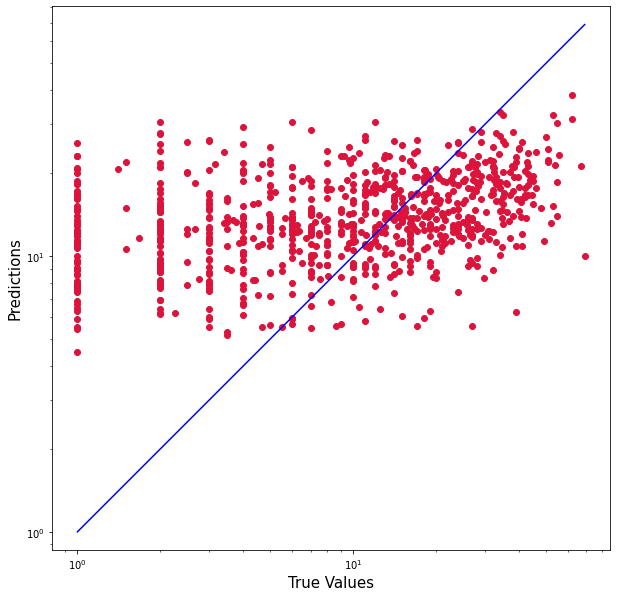

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, XGB_hyperparam.predict(xgb.DMatrix(X_test)), c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(XGB_hyperparam.predict(xgb.DMatrix(X_test))), max(y_test))
p2 = min(min(XGB_hyperparam.predict(xgb.DMatrix(X_test))), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## pull from MusixMatch

In [ ]:
genres_joined_electro.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,analysis_url,duration_ms,time_signature,song_name,Unnamed: 0,title,href,popularity,name,first_artist
3319,0.413,0.924,9,-3.767,0,0.0418,0.00364,0.784000,0.1080,0.0708,...,https://api.spotify.com/v1/audio-analysis/3cqW...,261401,4,Never Be Alone,NaN,NaN,https://api.spotify.com/v1/tracks/3cqWZkSohwFW...,28.0,Never Be Alone,T & Sugah
3335,0.537,0.906,8,-1.167,0,0.0651,0.13300,0.018700,0.3190,0.5040,...,https://api.spotify.com/v1/audio-analysis/507U...,215172,4,Desire (with Dimension),NaN,NaN,https://api.spotify.com/v1/tracks/507UUx311ghf...,62.0,Desire (with Dimension),Sub Focus
16006,0.630,0.928,9,-2.787,0,0.0331,0.19900,0.124000,0.1480,0.4650,...,https://api.spotify.com/v1/audio-analysis/0azC...,222160,4,This Is What You Came For (feat. Rihanna),NaN,NaN,https://api.spotify.com/v1/tracks/0azC730Exh71...,79.0,This Is What You Came For (feat. Rihanna),Calvin Harris
16060,0.572,0.802,5,-5.286,0,0.0412,0.01250,0.000101,0.1350,0.5550,...,https://api.spotify.com/v1/audio-analysis/3oeB...,193103,4,Out of My Head,NaN,NaN,https://api.spotify.com/v1/tracks/3oeBaOmuWeNP...,39.0,Out of My Head,Prefekt
16063,0.520,0.789,0,-7.717,1,0.0433,0.00491,0.000013,0.0816,0.4160,...,https://api.spotify.com/v1/audio-analysis/697M...,216347,4,I Miss You,NaN,NaN,https://api.spotify.com/v1/tracks/697MjF1454XK...,24.0,I Miss You,Jeff Slaugh


In [ ]:
musixmatch = Musixmatch(musix_cid)

def parse_lyrics(df):
  empty = []
  for row, artist in df.first_artist.iteritems():
    song_title = df['name'].loc[row]
    lyrics_return = ''
    #print(song_title)
    #print(artist)
    try:
      track_return = musixmatch.matcher_track_get(song_title, artist)
      if track_return['message']['body']['track']['has_lyrics'] == 1:
        lyrics_return = musixmatch.track_lyrics_get(track_return['message']['body']['track']['track_id'])['message']['body']['lyrics']['lyrics_body']
    except:
      lyrics_return = ''
    empty.append(lyrics_return)
  return empty

full_lyrics = parse_lyrics(genres_joined_electro)

In [52]:
genres_joined_electro['lyrics'] = full_lyrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
## clean lyrics
genres_joined_electro['lyrics_clean'] = genres_joined_electro['lyrics'].str.replace('******* This Lyrics is NOT for Commercial use *******\n(1409622602394)', '',regex=False).str.replace('\n', ' ', regex=False)
genres_joined_electro['char_len'] = genres_joined_electro['lyrics_clean'].str.len()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
(genres_joined_electro['char_len'] == 0).astype(int).sum()

7051

In [73]:
genres_joined_electro.to_csv('mapped_data_w_lyrics.csv')

In [84]:
sia = SentimentIntensityAnalyzer()

In [101]:
def get_sentiment(df):
  empty = []
  for lyrics in df.lyrics_clean:
    output = sia.polarity_scores(lyrics)
    empty.append(output)
  return empty

sentiment_scores = pd.DataFrame(get_sentiment(genres_joined_electro))
final_sentiment = pd.concat([genres_joined_electro.reset_index(), sentiment_scores.reset_index()], axis=1)

In [102]:
final_sentiment

,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,name,first_artist,lyrics,lyrics_clean,char_len,index,neg,neu,pos,compound
0,3319,0.413,0.924,9,-3.767,0,0.0418,0.00364,0.784000,0.1080,...,Never Be Alone,T & Sugah,,,0,0,0.000,0.000,0.000,0.0000
1,3335,0.537,0.906,8,-1.167,0,0.0651,0.13300,0.018700,0.3190,...,Desire (with Dimension),Sub Focus,"Oh, I've been waiting\nI've been waiting all t...","Oh, I've been waiting I've been waiting all th...",391,1,0.000,0.768,0.232,0.9661
2,16006,0.630,0.928,9,-2.787,0,0.0331,0.19900,0.124000,0.1480,...,This Is What You Came For (feat. Rihanna),Calvin Harris,"Baby, this is what you came for\nLightning str...","Baby, this is what you came for Lightning stri...",457,2,0.056,0.944,0.000,-0.6124
3,16060,0.572,0.802,5,-5.286,0,0.0412,0.01250,0.000101,0.1350,...,Out of My Head,Prefekt,Out-Out of my head\n\nI'm losing my focus\nTak...,Out-Out of my head I'm losing my focus Taking...,457,3,0.067,0.886,0.047,-0.4215
4,16063,0.520,0.789,0,-7.717,1,0.0433,0.00491,0.000013,0.0816,...,I Miss You,Jeff Slaugh,,,0,4,0.000,0.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8351,36524,0.622,0.812,0,-5.364,0,0.0375,0.12500,0.942000,0.1400,...,Gold,Ownglow,,,0,8351,0.000,0.000,0.000,0.0000
8352,36525,0.366,0.933,8,-3.826,0,0.0982,0.02210,0.001940,0.1760,...,Demons,T & Sugah,,,0,8352,0.000,0.000,0.000,0.0000
8353,36526,0.676,0.630,10,-8.019,0,0.3530,0.33300,0.612000,0.1650,...,Bitter Professional,Sinic,,,0,8353,0.000,0.000,0.000,0.0000
8354,36529,0.664,0.887,11,-4.635,0,0.0664,0.00025,0.122000,0.1190,...,Don't Hold Back,Bachelors of Science,,,0,8354,0.000,0.000,0.000,0.0000


In [103]:
agg_cols = {'danceability':'mean',
            'energy':'mean',
            'key': 'mean',
            'loudness':'mean',
            #'mode':'mean',
            'speechiness':'mean',
            'acousticness':'mean',
            'instrumentalness':'mean',
            'liveness': 'mean',
            'valence':'mean',
            'tempo':'mean',
            'neg':'mean',
            'neu':'mean',
            'pos':'mean',
            'compound':'mean',
            'popularity': 'mean'}

electro_agg_metrics = final_sentiment.groupby('first_artist').agg(agg_cols)

electro_agg_metrics

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,neg,neu,pos,compound,popularity
first_artist,,,,,,,,,,,,,,,
1991,0.451444,0.878556,4.944444,-3.23400,0.046628,0.012991,0.340653,0.235772,0.351944,174.024111,0.091444,0.660389,0.025778,-0.242033,32.333333
1st in Line,0.194000,0.999000,10.000000,-4.74900,0.097300,0.000621,0.915000,0.344000,0.257000,137.979000,0.000000,0.000000,0.000000,0.000000,13.000000
2000 And One,0.787750,0.850500,4.750000,-8.60525,0.045800,0.000097,0.862500,0.209750,0.066175,129.759250,0.000000,0.000000,0.000000,0.000000,8.250000
2pole,0.740000,0.812375,5.000000,-7.91075,0.088175,0.013872,0.808125,0.111025,0.111687,130.130750,0.000000,0.000000,0.000000,0.000000,13.125000
4 Strings,0.485550,0.869150,5.050000,-7.64460,0.066450,0.004663,0.317804,0.273420,0.098530,135.702300,0.028300,0.293850,0.027850,0.022930,8.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tEho & Tran,0.762000,0.444000,4.000000,-13.91500,0.049700,0.013200,0.877000,0.059000,0.366000,121.994000,0.000000,0.000000,0.000000,0.000000,2.000000
tranzLift,0.509000,0.926750,6.000000,-7.62425,0.071125,0.000491,0.882000,0.340000,0.186750,138.497250,0.000000,0.000000,0.000000,0.000000,4.750000
twoloud,0.735000,0.853000,0.000000,-6.34200,0.074800,0.000719,0.393000,0.158000,0.489000,124.976000,0.000000,0.000000,0.000000,0.000000,6.000000


In [104]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(electro_agg_metrics.drop('popularity', axis = 1), 
                                                                            electro_agg_metrics.popularity,
                                                    random_state = 1111,
                                                    test_size = 0.3)

In [106]:
## Create dictionary to track model results
results = {}

def add_results(y_pred, model_name):
    ## Add results of test data to tracker, with user input to ensure data is overwritten on purpose
    if model_name in results.keys():
        userIn = input("Model already in dictionary. Add? ").lower()
        if userIn == 'yes':
            results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
        else:
            pass
    else:
        results[model_name] = round(sklearn.metrics.mean_squared_error(y_test, y_pred), 2)**.5
    print(results)

In [107]:
XGB_MVP = xgb.XGBRegressor(objective='reg:squarederror',
                                seed=100).fit(X_train, y_train)
add_results(XGB_MVP.predict(X_test), "XGB_Base")

{'XGB_Base': 11.43241006962224}


In [108]:
## Run GridSearchCV on max_depth, min_child_weight, n_estimators, and subsample

param_test = {
 'max_depth':range(2,5,1),
 'min_child_weight':range(3,10,2),
 'subsample':[i/100.0 for i in range(70,90,5)],
 'n_estimator':range(150,300,50)
}

gsearch1 = sklearn.model_selection.GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eta=0.025,
                                                                           seed=100),param_grid=param_test, 
                                                                           cv=4)
gsearch1.fit(X_train, y_train)
gsearch1.best_estimator_

XGBRegressor(eta=0.025, max_depth=2, min_child_weight=9, n_estimator=150,
             objective='reg:squarederror', seed=100, subsample=0.85)

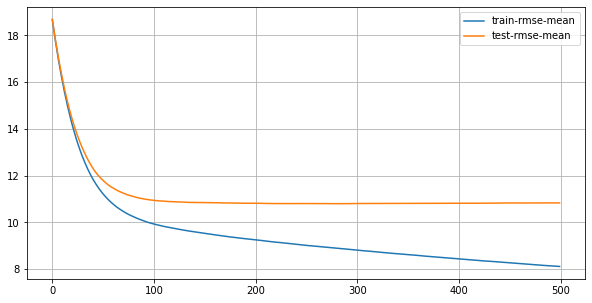

In [109]:
## Select final number of estimators
params = {'eta':0.025, 'seed':100, 
         'max_depth':3, 'min_child_weight':9, 'subsample':0.85, 'objective':'reg:squarederror'}

## Run CV to determine the number of round
CVRun = xgb.cv(
            params=params,
            dtrain=xgb.DMatrix(X_train, label=y_train),
            num_boost_round=500,
            nfold=4,
            metrics='rmse',
            seed=100)

CVRun.drop(['train-rmse-std', 'test-rmse-std'], axis=1, inplace=True)
CVRun.plot(figsize = (10,5), grid = True)

In [110]:
## Selected 300 as the number of rounds to avoid over fitting

XGB_hyperparam = xgb.train(params, xgb.DMatrix(X_train, label=y_train), 125)
add_results(XGB_hyperparam.predict(xgb.DMatrix(X_test)), "XGB_Hyperparam")

{'XGB_Base': 11.43241006962224, 'XGB_Hyperparam': 11.280514172678478}


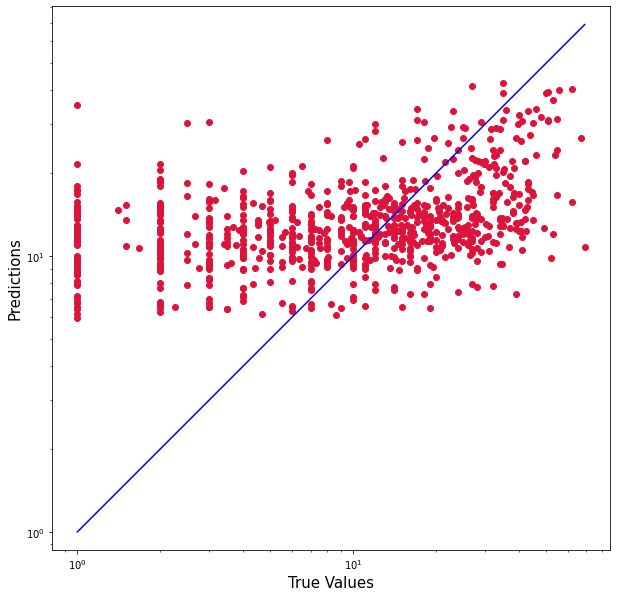

In [111]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, XGB_hyperparam.predict(xgb.DMatrix(X_test)), c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(XGB_hyperparam.predict(xgb.DMatrix(X_test))), max(y_test))
p2 = min(min(XGB_hyperparam.predict(xgb.DMatrix(X_test))), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()